<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Да! Можно сделать эмбединги для слов фиксированной размерности, а затем просто применять к ним одномерную свёртку.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

LSTM "может помнить" много предыдущих состояний, а не последнее.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Например, для классификации видео. Для изображений мы используем свёрточные нейросети, чтобы получить вектор представления для каждого, а затем их можно запихивать в RNN и, например, предсказывать следующий кадр.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Из-за маленькой размерности мы будем терять много информации, из-за слишком большой в силу проклятия размерности расстояния между словами будут тяжело различимы.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
#!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
#!tar -xvzf data.tar.gz

### Data preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 3.19 s, sys: 759 ms, total: 3.95 s
Wall time: 4.25 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [6]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
word_counts = {}
for img in captions:
    for caption in img:
        for word in caption:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

vocab  = ['#UNK#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8479,  2850,  7827,  4134, 10056,  9932,  5913,  4857,  6764,
         1241,  3978,  6252,  8132,    -1,    -1],
       [ 8479,  6764,  1241,  8900,  1019,  9093,  6252,  3978,  8254,
          725,  5913,  8132,    -1,    -1,    -1],
       [ 8479,  8715,  4134, 10056,  9932,  5913,  4857,  6764,  5625,
         8637,   533,  5468,  7113,  5153,  8132],
       [ 8479,  8715,  8895,  3067,  2536,   779,  8715,  8895,  1556,
         8132,    -1,    -1,    -1,    -1,    -1],
       [ 8479,  2850,  7827,  4134, 10056,  9932,  5913,  4857,  6764,
         1241,   533,  5468,  8917,  8132,    -1]], dtype=int32)

### Mah Neural Network

In [9]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 200 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

MAX_SENTENCE_LENGTH = 50

In [10]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

Can not use cuDNN on context None: Device not supported
Mapped name None to device cuda: GF117 (0000:01:00.0)


In [11]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [12]:
#network inputs
l_words = InputLayer((None, MAX_SENTENCE_LENGTH), sentences)
l_mask = InputLayer((None, MAX_SENTENCE_LENGTH), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, input_size=n_tokens, output_size=LSTM_UNITS)

In [13]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
#l_image_features_small = <Apply Dropout Layer to regularise your Net>
#l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>
l_image_features_small = DropoutLayer(l_image_features, p=0.5)
l_image_features_small = DenseLayer(l_image_features_small, num_units=LSTM_UNITS)
l_image_features_small = DropoutLayer(l_image_features_small, p=0.5)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [14]:
l_image_embeddings = ReshapeLayer(l_image_features_small, ([0], -1, [1]))
l_image_embeddings.output_shape
l_rnn_input = ConcatLayer([l_image_embeddings, l_word_embeddings], axis=1)

In [17]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_rnn_input,
                    num_units=LSTM_UNITS,
                    mask_input=l_mask,
                    grad_clipping=5.)

decoder = DropoutLayer(decoder, p=0.5)

In [18]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ", broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, 51, 10371)

broadcasted decoder shape =  (None, 200)
output shape =  (None, 51, 10371)


In [19]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = T.mean(loss[output_mask.nonzero()])

In [20]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights, learning_rate=0.001)

In [21]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [22]:
captions = np.array(captions)

In [23]:
from random import choice

def generate_batch(images, captions, batch_size, max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [24]:
generate_batch(img_codes,captions, 2)

(array([[-0.59046185, -3.33208561, -2.61767173, ..., -1.65386581,
          0.06919488,  4.22674751],
        [-5.31453896, -0.8979184 , -0.17014587, ..., -2.86045861,
         -1.29903173,  2.02261305]], dtype=float32),
 array([[ 8479,  8715,  1370,  1556,  3978,  2850,  7827,   179, 10257,
          3015,  8715, 10012,  8132],
        [ 8479,  2850,  1027,  9960,  3431,  4140,  8715,  6888,  7892,
          8132,    -1,    -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [25]:
batch_size = 25
n_epochs   = 128 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 8 #how many batches are used for validation after each epoch

In [26]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  2%|▏         | 1/50 [00:00<00:07,  6.70it/s]


Epoch: 0, train loss: 7.37355039597, val loss: 5.74196279049


  2%|▏         | 1/50 [00:00<00:06,  7.50it/s]


Epoch: 1, train loss: 5.59043673515, val loss: 5.46520185471


  2%|▏         | 1/50 [00:00<00:06,  7.07it/s]


Epoch: 2, train loss: 5.36235731125, val loss: 5.29481375217


  2%|▏         | 1/50 [00:00<00:06,  7.07it/s]


Epoch: 3, train loss: 5.22763150215, val loss: 5.23023480177


  2%|▏         | 1/50 [00:00<00:05,  9.24it/s]


Epoch: 4, train loss: 5.1580945015, val loss: 5.12697923183


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.04850329399, val loss: 4.99283528328


  2%|▏         | 1/50 [00:00<00:09,  5.43it/s]


Epoch: 6, train loss: 5.04432724953, val loss: 4.88322079182


  2%|▏         | 1/50 [00:00<00:09,  5.13it/s]


Epoch: 7, train loss: 4.97934561729, val loss: 4.9628123641


  2%|▏         | 1/50 [00:00<00:06,  8.12it/s]


Epoch: 8, train loss: 4.9289057827, val loss: 4.94349086285


  2%|▏         | 1/50 [00:00<00:07,  6.35it/s]


Epoch: 9, train loss: 4.90906718254, val loss: 4.90484285355


  2%|▏         | 1/50 [00:00<00:05,  8.73it/s]


Epoch: 10, train loss: 4.90167756081, val loss: 4.8217009306


  2%|▏         | 1/50 [00:00<00:06,  7.67it/s]


Epoch: 11, train loss: 4.88492630005, val loss: 4.8049570322


  2%|▏         | 1/50 [00:00<00:08,  5.53it/s]


Epoch: 12, train loss: 4.81923768044, val loss: 4.83415722847


  2%|▏         | 1/50 [00:00<00:07,  6.20it/s]


Epoch: 13, train loss: 4.83867622375, val loss: 4.86404049397


  2%|▏         | 1/50 [00:00<00:06,  7.60it/s]


Epoch: 14, train loss: 4.85921326637, val loss: 4.80891138315


  2%|▏         | 1/50 [00:00<00:07,  6.36it/s]


Epoch: 15, train loss: 4.78565956116, val loss: 4.75452888012


  2%|▏         | 1/50 [00:00<00:07,  6.71it/s]


Epoch: 16, train loss: 4.81980988503, val loss: 4.71588551998


  2%|▏         | 1/50 [00:00<00:06,  7.43it/s]


Epoch: 17, train loss: 4.77624266624, val loss: 4.82193177938


  2%|▏         | 1/50 [00:00<00:06,  7.84it/s]


Epoch: 18, train loss: 4.77827028275, val loss: 4.69223719835


  2%|▏         | 1/50 [00:00<00:05,  8.38it/s]


Epoch: 19, train loss: 4.71603298187, val loss: 4.7531644702


  2%|▏         | 1/50 [00:00<00:08,  5.71it/s]


Epoch: 20, train loss: 4.77016217232, val loss: 4.61778306961


  2%|▏         | 1/50 [00:00<00:06,  7.38it/s]


Epoch: 21, train loss: 4.72825351715, val loss: 4.76506614685


  2%|▏         | 1/50 [00:00<00:06,  7.08it/s]


Epoch: 22, train loss: 4.69544430733, val loss: 4.70745289326


  2%|▏         | 1/50 [00:00<00:08,  5.88it/s]


Epoch: 23, train loss: 4.69720615387, val loss: 4.64504116774


  2%|▏         | 1/50 [00:00<00:08,  6.08it/s]


Epoch: 24, train loss: 4.67265002251, val loss: 4.74245858192


  2%|▏         | 1/50 [00:00<00:07,  6.73it/s]


Epoch: 25, train loss: 4.6360592556, val loss: 4.6298764348


  2%|▏         | 1/50 [00:00<00:06,  7.89it/s]


Epoch: 26, train loss: 4.62035094261, val loss: 4.6415719986


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 4.63026370049, val loss: 4.56966292858


  2%|▏         | 1/50 [00:00<00:06,  7.80it/s]


Epoch: 28, train loss: 4.60684096336, val loss: 4.53143531084


  2%|▏         | 1/50 [00:00<00:07,  6.36it/s]


Epoch: 29, train loss: 4.62571737289, val loss: 4.62638157606


  2%|▏         | 1/50 [00:00<00:06,  7.90it/s]


Epoch: 30, train loss: 4.62855998993, val loss: 4.41624838114


  2%|▏         | 1/50 [00:00<00:05,  8.87it/s]


Epoch: 31, train loss: 4.60152472496, val loss: 4.55727130175


  2%|▏         | 1/50 [00:00<00:06,  7.53it/s]


Epoch: 32, train loss: 4.53595801353, val loss: 4.58309823275


  2%|▏         | 1/50 [00:00<00:08,  5.78it/s]


Epoch: 33, train loss: 4.57260320663, val loss: 4.52614688873


  2%|▏         | 1/50 [00:00<00:08,  5.46it/s]


Epoch: 34, train loss: 4.49554980278, val loss: 4.49684971571


  2%|▏         | 1/50 [00:00<00:07,  6.82it/s]


Epoch: 35, train loss: 4.52682313919, val loss: 4.52440452576


  2%|▏         | 1/50 [00:00<00:07,  6.29it/s]


Epoch: 36, train loss: 4.52715459824, val loss: 4.4395929575


  2%|▏         | 1/50 [00:00<00:07,  6.36it/s]


Epoch: 37, train loss: 4.50894709587, val loss: 4.479585886


  2%|▏         | 1/50 [00:00<00:08,  6.06it/s]


Epoch: 38, train loss: 4.53753198624, val loss: 4.51095414162


  2%|▏         | 1/50 [00:00<00:08,  6.12it/s]


Epoch: 39, train loss: 4.54603292465, val loss: 4.51614075899


  2%|▏         | 1/50 [00:00<00:07,  6.23it/s]


Epoch: 40, train loss: 4.45785877228, val loss: 4.47029459476


  2%|▏         | 1/50 [00:00<00:07,  6.42it/s]


Epoch: 41, train loss: 4.46956818581, val loss: 4.51063627005


  2%|▏         | 1/50 [00:00<00:06,  7.42it/s]


Epoch: 42, train loss: 4.50996051788, val loss: 4.40391355753


  2%|▏         | 1/50 [00:00<00:08,  5.64it/s]


Epoch: 43, train loss: 4.53396338463, val loss: 4.41414433718


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 4.46063770294, val loss: 4.36161532998


  2%|▏         | 1/50 [00:00<00:05,  8.32it/s]


Epoch: 45, train loss: 4.40813751221, val loss: 4.42925000191


  2%|▏         | 1/50 [00:00<00:09,  5.17it/s]


Epoch: 46, train loss: 4.45481999874, val loss: 4.48270356655


  2%|▏         | 1/50 [00:00<00:06,  7.35it/s]


Epoch: 47, train loss: 4.40528392315, val loss: 4.47895032167


  2%|▏         | 1/50 [00:00<00:07,  6.17it/s]


Epoch: 48, train loss: 4.41114602566, val loss: 4.45616716146


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 4.42182498932, val loss: 4.25193545222


  2%|▏         | 1/50 [00:00<00:06,  7.15it/s]


Epoch: 50, train loss: 4.40579897881, val loss: 4.44637489319


  2%|▏         | 1/50 [00:00<00:07,  6.86it/s]


Epoch: 51, train loss: 4.34085189342, val loss: 4.43082356453


  2%|▏         | 1/50 [00:00<00:05,  8.33it/s]


Epoch: 52, train loss: 4.43359146118, val loss: 4.47015696764


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 4.35174953461, val loss: 4.26152819395


  2%|▏         | 1/50 [00:00<00:06,  7.53it/s]


Epoch: 54, train loss: 4.3719938755, val loss: 4.25201508403


  2%|▏         | 1/50 [00:00<00:06,  7.20it/s]


Epoch: 55, train loss: 4.39687444687, val loss: 4.27746069431


  2%|▏         | 1/50 [00:00<00:07,  6.82it/s]


Epoch: 56, train loss: 4.38060520649, val loss: 4.225387007


  2%|▏         | 1/50 [00:00<00:06,  7.41it/s]


Epoch: 57, train loss: 4.34122486591, val loss: 4.45875817537


  2%|▏         | 1/50 [00:00<00:07,  6.68it/s]


Epoch: 58, train loss: 4.31969612598, val loss: 4.38516527414


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 4.31114109516, val loss: 4.28908827901


  2%|▏         | 1/50 [00:00<00:07,  6.75it/s]


Epoch: 60, train loss: 4.33414070606, val loss: 4.45042353868


  2%|▏         | 1/50 [00:00<00:06,  7.73it/s]


Epoch: 61, train loss: 4.29952327251, val loss: 4.34122055769


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 4.29607899189, val loss: 4.1960914731


  2%|▏         | 1/50 [00:00<00:07,  6.50it/s]


Epoch: 63, train loss: 4.38829059601, val loss: 4.45805603266


  2%|▏         | 1/50 [00:00<00:07,  6.89it/s]


Epoch: 64, train loss: 4.28804726601, val loss: 4.23052144051


  2%|▏         | 1/50 [00:00<00:06,  7.32it/s]


Epoch: 65, train loss: 4.27955878258, val loss: 4.22093743086


  2%|▏         | 1/50 [00:00<00:06,  7.53it/s]


Epoch: 66, train loss: 4.28170259476, val loss: 4.09593421221


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 4.24031349182, val loss: 4.23745656013


  2%|▏         | 1/50 [00:00<00:07,  6.36it/s]


Epoch: 68, train loss: 4.29112438679, val loss: 4.28414425254


  2%|▏         | 1/50 [00:00<00:06,  7.23it/s]


Epoch: 69, train loss: 4.29955178261, val loss: 4.32919955254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 4.306784935, val loss: 4.2778134346


  2%|▏         | 1/50 [00:00<00:05,  9.65it/s]


Epoch: 71, train loss: 4.36723957062, val loss: 4.1975979507


  2%|▏         | 1/50 [00:00<00:05,  8.82it/s]


Epoch: 72, train loss: 4.25989827156, val loss: 4.35118940473


  2%|▏         | 1/50 [00:00<00:08,  6.07it/s]


Epoch: 73, train loss: 4.24359908581, val loss: 4.28647059202


  2%|▏         | 1/50 [00:00<00:07,  6.37it/s]


Epoch: 74, train loss: 4.24075135231, val loss: 4.23583397269


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 4.23396989822, val loss: 4.32167047262


  2%|▏         | 1/50 [00:00<00:06,  7.60it/s]


Epoch: 76, train loss: 4.21004910469, val loss: 4.39136660099


  2%|▏         | 1/50 [00:00<00:07,  6.37it/s]


Epoch: 77, train loss: 4.2687857151, val loss: 4.3973352313


  2%|▏         | 1/50 [00:00<00:07,  6.94it/s]


Epoch: 78, train loss: 4.26600648403, val loss: 4.22168964148


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 4.20521568775, val loss: 4.15804624557


  2%|▏         | 1/50 [00:00<00:06,  7.66it/s]


Epoch: 80, train loss: 4.19257629395, val loss: 4.26287311316


  2%|▏         | 1/50 [00:00<00:07,  6.49it/s]


Epoch: 81, train loss: 4.2790959692, val loss: 4.30247169733


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 4.19099013805, val loss: 4.21160066128


  2%|▏         | 1/50 [00:00<00:08,  5.56it/s]


Epoch: 83, train loss: 4.22205610275, val loss: 4.13671028614


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 4.17208868027, val loss: 4.15984141827


  2%|▏         | 1/50 [00:00<00:08,  6.03it/s]


Epoch: 85, train loss: 4.20840389252, val loss: 4.28196048737


  2%|▏         | 1/50 [00:00<00:08,  5.96it/s]


Epoch: 86, train loss: 4.17925434589, val loss: 4.26952877641


  2%|▏         | 1/50 [00:00<00:06,  7.01it/s]


Epoch: 87, train loss: 4.25341362, val loss: 4.20105147362


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 4.19972435474, val loss: 4.19742903113


  2%|▏         | 1/50 [00:00<00:06,  7.34it/s]


Epoch: 89, train loss: 4.1433934164, val loss: 4.16204586625


  2%|▏         | 1/50 [00:00<00:06,  8.06it/s]


Epoch: 90, train loss: 4.20792670727, val loss: 4.29983961582


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 4.21612101078, val loss: 4.13625201583


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 4.18392907619, val loss: 4.21414521337


  2%|▏         | 1/50 [00:00<00:06,  7.41it/s]


Epoch: 93, train loss: 4.18346678734, val loss: 4.27704244852


  2%|▏         | 1/50 [00:00<00:07,  6.51it/s]


Epoch: 94, train loss: 4.18915082455, val loss: 4.13052457571


  2%|▏         | 1/50 [00:00<00:08,  6.03it/s]


Epoch: 95, train loss: 4.12889019966, val loss: 4.10019406676


  2%|▏         | 1/50 [00:00<00:06,  7.33it/s]


Epoch: 96, train loss: 4.2028653574, val loss: 4.28890910745


  2%|▏         | 1/50 [00:00<00:06,  7.79it/s]


Epoch: 97, train loss: 4.13504546642, val loss: 3.9676784575


  2%|▏         | 1/50 [00:00<00:07,  6.97it/s]


Epoch: 98, train loss: 4.21193157673, val loss: 4.12863841653


  2%|▏         | 1/50 [00:00<00:08,  6.09it/s]


Epoch: 99, train loss: 4.15259645462, val loss: 4.0724914968


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 100, train loss: 4.17049465179, val loss: 4.03317564726


  2%|▏         | 1/50 [00:00<00:08,  5.68it/s]


Epoch: 101, train loss: 4.20273808956, val loss: 4.27323555946


  2%|▏         | 1/50 [00:00<00:07,  6.96it/s]


Epoch: 102, train loss: 4.14223894596, val loss: 4.00907701254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 103, train loss: 4.15883129597, val loss: 4.24816945195


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 104, train loss: 4.12710621834, val loss: 4.16433903575


  2%|▏         | 1/50 [00:00<00:07,  6.86it/s]


Epoch: 105, train loss: 4.16837579727, val loss: 4.18332314491


  2%|▏         | 1/50 [00:00<00:08,  6.12it/s]


Epoch: 106, train loss: 4.09338964939, val loss: 4.13665801287


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 107, train loss: 4.13697172165, val loss: 4.2446796298


  2%|▏         | 1/50 [00:00<00:08,  5.65it/s]


Epoch: 108, train loss: 4.12494955063, val loss: 4.07034930587


  2%|▏         | 1/50 [00:00<00:07,  6.69it/s]


Epoch: 109, train loss: 4.11036366463, val loss: 4.12948906422


  2%|▏         | 1/50 [00:00<00:09,  5.13it/s]


Epoch: 110, train loss: 4.14446120739, val loss: 4.20471736789


  2%|▏         | 1/50 [00:00<00:07,  6.54it/s]


Epoch: 111, train loss: 4.07380485535, val loss: 4.04966598749


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 112, train loss: 4.10384217262, val loss: 4.14952033758


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 113, train loss: 4.17445791245, val loss: 4.23589253426


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 114, train loss: 4.13039820194, val loss: 4.05855998397


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 115, train loss: 4.111736269, val loss: 4.01951992512


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 116, train loss: 4.10572425365, val loss: 4.11803242564


  2%|▏         | 1/50 [00:00<00:09,  5.29it/s]


Epoch: 117, train loss: 4.10373086929, val loss: 4.15812009573


  2%|▏         | 1/50 [00:00<00:06,  7.58it/s]


Epoch: 118, train loss: 4.13216547489, val loss: 4.13377279043


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 119, train loss: 4.09219102859, val loss: 4.0191193819


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 120, train loss: 4.09643676758, val loss: 3.90527975559


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 121, train loss: 4.10249637127, val loss: 4.12504374981


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 122, train loss: 4.11127532005, val loss: 4.0349162817


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 123, train loss: 4.1584214592, val loss: 3.94368505478


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 124, train loss: 4.09459141731, val loss: 4.05047386885


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 125, train loss: 4.08764273643, val loss: 4.00279867649


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 126, train loss: 4.02159818172, val loss: 4.13855838776


100%|██████████| 50/50 [00:10<00:00,  4.82it/s]



Epoch: 127, train loss: 4.07189653397, val loss: 3.93862509727
Finish :)


### apply trained model

In [33]:
%%time
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model, preprocess, MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

CPU times: user 7.38 s, sys: 60 ms, total: 7.44 s
Wall time: 7.48 s


In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

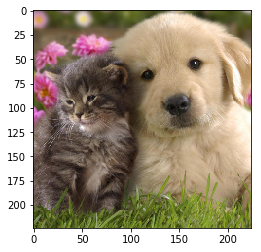

In [35]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [36]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [37]:
for i in range(20):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a cat of while red together bottles long luggage down
#UNK# sheep brown on is wooden in near kitchen
an cat dog on in leash compartment various
three cat looking across #UNK# ghost
a girl in cattle room eating a bath floor a chips
a young shaped with white cat of down sleeping and her
2 close past of straw animals along on to sunny area
on groom adult a jeans sleeping tied a a smiling dog of a camera hat a checkered to children her her lamp while the in look hat
a large sleeping dog by top cup a outdoor bear
a sits takes some laptop other with in puppy
a lamb dog running game a coin cooking ball a it fence holding the lap swing
the clothes are nintendo floats video a floor
the stuffed rubbing bear photo down her a in covered ocean
a cat is next out some television on with room
some suit a graze and open the something of
a furry bear is a on on grazes ground clowns a it beanie a
a veggies is cake in grey center looking a a
woman action frisbee to a colorful bear enclosed
a giraffe red o

In [38]:
for i in range(20):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a twin doll standing eating the
we lambs posing on at grass podium
a noodles flying in out ones its a
a dog with sleeping standing hanging a on eating desk
a cats is on in bed white well toys it next a a window counter and a locomotive bus the it
a stuffed dog in on giraffe tray some end
a couple on giraffe lying on some floor and people
a spring is laying her the on close tiled of
a brown sits cat by the adult rail in the room
a there dog two woman piled next top each a
a closeup puppy a for a mouth a is out
#UNK# row white little garbage frosted on bear desk snow
a berries feeding sitting a line in one sunlight
large cat of a white flown lighting tall another
a cat is driving on looking back
a standing that close a a black bear a the soccer
the zebras of laying other on the ground on
a dog wearing sniffing cone in to
two sleeps brushing a teeth together
a pink are birthday a and and is in


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 